In [4]:
# load libraries
from pl_temp_fit import PLPYMCModel, ELPYMCModel
import arviz as az
import pymc as pm
print(f"Running on PyMC v{pm.__version__}")
import numpy as np
import os
import matplotlib.pyplot as plt
from pl_temp_fit import ELPYMCModel



Running on PyMC v5.10.3


In [65]:
#initialise parameters for the model
number_free_parameters , sigma, Temp_std_err, hws_std_err, relative_intensity_std_error = 3, 0.001, 2, 0.001, 0.05
temperature_list = np.array([300.0, 250.0, 200.0, 150.0, 80.0])
hws = np.arange(0.8, 2, 0.02)
num_samples = 1000
num_tune = 1000

model_config = {
            "number_free_parameters": number_free_parameters,
            "sigma": sigma,
            "Temp_std_err": Temp_std_err,
            "hws_std_err": hws_std_err,
            "relative_intensity_std_error": relative_intensity_std_error,
        }
X = {'temperature_list':temperature_list, 'hws':hws}
# generate the data
save_folder = (
    "test_results_EL_09_01/num_samples="
    + str(num_samples)
    + " num_tune=" + str(num_tune)
    + " sigma=" + str(sigma)
    + " temperature_list=" + str(len(temperature_list))
    + " number_free_parameters=" + str(number_free_parameters)
    + " Temp_std_err="+str(Temp_std_err)
    + " hws_std_err="+str(hws_std_err)
    + " relative_intensity_std_error="+str(relative_intensity_std_error)
)
os.makedirs(save_folder, exist_ok=True)

In [66]:
#generate data
def generate_data(temperature_list, hws,sigma,Temp_std_err,hws_std_err,relative_intensity_std_error,number_free_parameters,true_parameters = None,
                  **kwargs):
    if true_parameters is None:
        E_true = 1.4
        k_EXCT_true, fosc_CT_true = 9, -2.3
        LI_true = 0.1
        L0_true = 0.1
        H0_true = 0.15
        true_parameters = [E_true, k_EXCT_true, fosc_CT_true, LI_true, L0_true, H0_true]

    else:
        E_true, k_EXCT_true, fosc_CT_true, LI_true, L0_true, H0_true = true_parameters
    # error in the temperature of the sample
    temperature_list = temperature_list+np.random.normal(0, Temp_std_err, len(temperature_list))
    # error in the detection wavelength
    hws = hws+np.random.normal(0, hws_std_err, len(hws))
    truemodel_El = ELPYMCModel.el_trial(
        true_parameters,
        temperature_list, hws
    ) 
    # relative intensity error
    relative_intensity_model = np.max(truemodel_El, axis=0)/max(truemodel_El.reshape(-1, 1))
    relative_intensity_model_error = relative_intensity_model + np.random.normal(0, relative_intensity_std_error, len(relative_intensity_model))
    relative_intensity_model_error= relative_intensity_model_error/np.max(relative_intensity_model_error)
    truemodel_El=truemodel_El * relative_intensity_model_error / relative_intensity_model
    relative_intensity_model = np.max(truemodel_El, axis=0)/max(truemodel_El.reshape(-1, 1))
    # uniform error accross the spectrum
    truemodel_El = truemodel_El+np.random.normal(0, sigma, size=(len(hws), len(temperature_list)))

    return truemodel_El, true_parameters
truemodel_pl, true_parameters = generate_data(temperature_list, hws, **model_config)


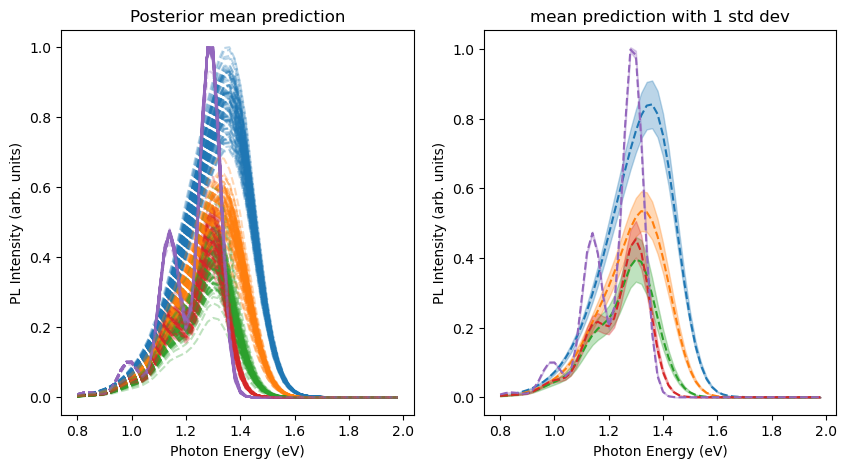

In [67]:
#plot the generated data
def plot_generated_data(truemodel_pl, temperature_list, hws, save_folder, model_config, savefig=True):
    fig, ax = plt.subplots(1,2, figsize=(10, 5))
    true_model_pl_list = []

    for x in range(100):
        truemodel_pl, true_parameters = generate_data(temperature_list, hws,**model_config)
        data_true_plot = truemodel_pl.reshape(len(hws), -1)
        data_true_plot = data_true_plot/max(data_true_plot.reshape(-1, 1))
        true_model_pl_list.append(data_true_plot.reshape(len(hws), len(temperature_list)))

        for i in range(len(temperature_list)):
            ax[0].plot(
                hws,
                data_true_plot[:, i],
                label="true" + str(temperature_list[i]) + " K",
                linestyle="--",
                color="C" + str(i),
                alpha=0.3,
            )
        ax[0].set_xlabel("Photon Energy (eV)")
        ax[0].set_ylabel("PL Intensity (arb. units)")
        ax[0].set_title("Posterior mean prediction")
    variance = np.var(np.array(true_model_pl_list), axis=0)
    mean_value_plot = np.mean(np.array(true_model_pl_list), axis=0)
    arg_max_variance = np.argmax(mean_value_plot, axis=0)

    for i in range(len(temperature_list)):
        
        ax[1].plot(
            hws,
            mean_value_plot[:, i],
            label="true" + str(temperature_list[i]) + " K",
            linestyle="--",
            color="C" + str(i),
        )
        ax[1].fill_between(
            hws,
            np.mean(np.array(true_model_pl_list), axis=0)[:, i]
            - np.sqrt(variance[:, i]),
            np.mean(np.array(true_model_pl_list), axis=0)[:, i]
            + np.sqrt(variance[:, i]),
            alpha=0.3,
            color="C" + str(i),
        )
        ax[1].set_xlabel("Photon Energy (eV)")
        ax[1].set_ylabel("PL Intensity (arb. units)")
        ax[1].set_title("mean prediction with 1 std dev")

    if savefig:
        fig.savefig(save_folder + "/generated_data.png")
    return mean_value_plot,variance,arg_max_variance
true_model_pl_list,variance,arg_max_variance = plot_generated_data(truemodel_pl, temperature_list, hws, save_folder, model_config, savefig=True)

(0.001, 1)

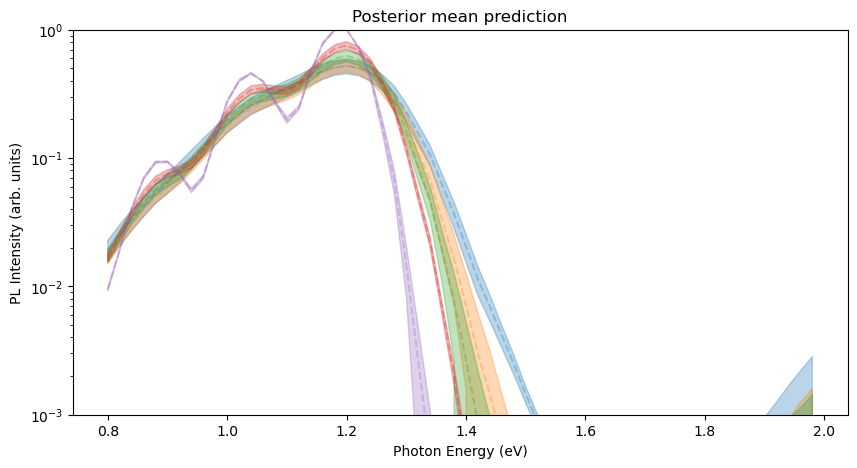

In [69]:
#transfer variance to new data
true_parameters=[1.3, 9, -2.3, 0.1, 0.1, 0.15]
mean_value_plot = np.mean(np.array(true_model_pl_list), axis=0)
truemodel_pl, true_parameters = generate_data(temperature_list, hws, **model_config, true_parameters=true_parameters)
truemodel_pl = truemodel_pl.reshape(len(hws), -1)
truemodel_pl = truemodel_pl/max(truemodel_pl.reshape(-1, 1))
variance_data = variance.copy()
argmax_data = np.argmax(truemodel_pl, axis=0)
for i in range(len(temperature_list)):
    variance_data[:, i] = np.roll(variance_data[:, i], argmax_data[i]-arg_max_variance[i])
fig, ax = plt.subplots(1,1, figsize=(10, 5))

for i in range(len(temperature_list)):
    ax.plot(
        hws,
        truemodel_pl[:, i],
        label="true" + str(temperature_list[i]) + " K",
        linestyle="--",
        color="C" + str(i),
        alpha=0.3,
    )
    ax.fill_between(
            hws,
            truemodel_pl[:, i]
            - np.sqrt(variance_data[:, i]),
            truemodel_pl[:, i]
            + np.sqrt(variance_data[:, i]),
            alpha=0.3,
            color="C" + str(i),
        )
ax.set_xlabel("Photon Energy (eV)")
ax.set_ylabel("PL Intensity (arb. units)")
ax.set_title("Posterior mean prediction")
ax.set_yscale('log')
ax.set_ylim([1e-3, 1])

In [73]:
from pl_temp_fit import ELPYMCModel
import importlib
importlib.reload(ELPYMCModel)
## initialise the model and run the fit
model = ELPYMCModel.ELPYMCModel()
for key, value in model_config.items():
    model.model_config[key] = value
print(model.model_config)      
model.sampler_config['step'] = "pm.DEMetropolis()"#"[pm.DEMetropolis([self.E,self.LI,self.sigma_E]),pm.DEMetropolis([self.L0,self.H0])]"  
print(model.sampler_config)
model.fit(X, truemodel_pl,sigma=variance_data , draws=num_samples, tune=num_tune, chains=4, step=model.sampler_config['step'] , return_inferencedata=True)
print(az.summary(model.idata))
model.plot_trace(true_parameters, save_folder=save_folder, savefig=True)
# save the data
model.idata.to_netcdf(save_folder + "/idata.nc")
model.plot_posterior_prediction(truemodel_pl,  temperature_list, hws, save_folder=save_folder, savefig=True)
fname = "/model.nc"
model.save(save_folder+fname)


{'number_free_parameters': 3, 'E': {'min': 1.0, 'max': 1.4}, 'k_EXCT': {'min': 8, 'max': 12}, 'fosc_CT': {'min': -4, 'max': 0}, 'LI': {'mu': 0.12, 'sigma': 0.01, 'lower': 0.05, 'upper': 0.15}, 'L0': {'mu': 0.12, 'sigma': 0.01, 'lower': 0.05, 'upper': 0.15}, 'H0': {'mu': 0.12, 'sigma': 0.01, 'lower': 0.12, 'upper': 0.18}, 'Temp_std_err': 2, 'hws_std_err': 0.001, 'relative_intensity_std_error': 0.05, 'sigma': 0.001}
{'draws': 10, 'tune': 5, 'chains': 3, 'step': 'pm.DEMetropolis()', 'return_inferencedata': True}
{'draws': 1000, 'tune': 1000, 'chains': 4, 'return_inferencedata': True, 'progressbar': True, 'random_seed': None}


/rds/general/user/ma11115/home/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pytensor/link/c/cmodule.py:1051: UserWarning: Removing key file /rds/general/user/ma11115/home/.pytensor/compiledir_Linux-4.18-el8_5.x86_64-x86_64-with-glibc2.28-x86_64-3.11.6-64/tmp05waugfu/key.pkl because the corresponding module is gone from the file system.
  warnings.warn(
/rds/general/user/ma11115/home/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pytensor/link/c/cmodule.py:1051: UserWarning: Removing key file /rds/general/user/ma11115/home/.pytensor/compiledir_Linux-4.18-el8_5.x86_64-x86_64-with-glibc2.28-x86_64-3.11.6-64/tmpa0mqnd5w/key.pkl because the corresponding module is gone from the file system.
  warnings.warn(
/rds/general/user/ma11115/home/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pytensor/link/c/cmodule.py:1051: UserWarning: Removing key file /rds/general/user/ma11115/home/.pytensor/compiledir_Linux-4.18-el8_5.x86_64-x86_64-with-glibc2.28-x86_64-3.11.6-64/tmpxjy5afz4

AttributeError: 'float' object has no attribute 'reshape'
Apply node that caused the error: LogLike(MakeVector{dtype='float64'}.0)
Toposort index: 4
Inputs types: [TensorType(float64, shape=(3,))]
Inputs shapes: [(3,)]
Inputs strides: [(8,)]
Inputs values: [array([ 1.2, 10. , -2. ])]
Outputs clients: [['output']]

Backtrace when the node is created (use PyTensor flag traceback__limit=N to make it longer):
  File "/rds/general/user/ma11115/home/anaconda3/envs/pymc_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3103, in _run_cell
    result = runner(coro)
  File "/rds/general/user/ma11115/home/anaconda3/envs/pymc_env/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
    coro.send(None)
  File "/rds/general/user/ma11115/home/anaconda3/envs/pymc_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3308, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "/rds/general/user/ma11115/home/anaconda3/envs/pymc_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3490, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):
  File "/rds/general/user/ma11115/home/anaconda3/envs/pymc_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/tmp/pbs.8691410.pbs/ipykernel_414849/2422843474.py", line 11, in <module>
    model.fit(X, truemodel_pl, draws=num_samples, tune=num_tune, chains=4, step=model.sampler_config['step'] , return_inferencedata=True)
  File "/rds/general/user/ma11115/home/pl_temp_fit/src/pl_temp_fit/ELPYMCModel.py", line 327, in fit
    sampler_config.update(**kwargs)
  File "/rds/general/user/ma11115/home/pl_temp_fit/src/pl_temp_fit/ELPYMCModel.py", line 137, in build_model
    pm.Potential("likelihood", logl(theta))

HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

In [52]:
argmax = np.argmax(truemodel_pl, axis=0)
argmax

array([20, 20, 20, 20, 19])

In [49]:
np.roll(variance, 5, axis=0)


array([[1.74293026e-51, 7.09951918e-14, 2.38581161e-17, 2.39492402e-22,
        4.27991708e-31],
       [1.37024893e-51, 2.31795087e-14, 5.77551679e-18, 3.64273259e-23,
        2.87383479e-32],
       [1.68324834e-51, 9.59412147e-15, 1.41143674e-18, 6.05022556e-24,
        2.17942824e-33],
       [1.41732256e-51, 3.51871158e-15, 4.42942082e-19, 1.05261191e-24,
        1.74914721e-34],
       [1.28193742e-51, 1.22932956e-15, 1.23814489e-19, 1.89675335e-25,
        1.72650559e-35],
       [1.40368994e-51, 6.22448167e-08, 3.75557403e-08, 3.66114841e-08,
        3.82148151e-08],
       [6.70022552e-08, 9.14277742e-08, 5.50504999e-08, 5.46131229e-08,
        5.39685362e-08],
       [3.54449239e-08, 1.78389574e-07, 1.07307422e-07, 9.07853072e-08,
        7.76126962e-08],
       [8.21648099e-09, 3.35637374e-07, 1.92367919e-07, 1.47178335e-07,
        9.48217408e-08],
       [5.02062006e-08, 5.49262588e-07, 3.38092498e-07, 2.48963598e-07,
        1.28310200e-07],
       [1.16502748e-07, 1.0557